In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dataset_path = "../datasets/ml-100k"

cuda:0


___

## USER

In [5]:
user = pd.read_csv(dataset_path+"/raw/u.user", header = None, sep = "|")
user.columns = ["user_id","age","gender","occupation","zipcode"]
user = user.drop(["zipcode"], axis = 1)

bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

user['agegroup'] = pd.cut(user['age'], bins, labels=names)
user = user.drop(["age"], axis = 1)
user.head()

,user_id,gender,occupation,agegroup
0,1,M,technician,20-29
1,2,F,other,51-60
2,3,M,writer,20-29
3,4,M,technician,20-29
4,5,F,other,30-39


In [6]:
columnsToEncode = ["agegroup","gender","occupation"]
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columnsToEncode, 1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names(columnsToEncode))], axis=1).reindex()
print(user_features.shape)
user_features.head()

(943, 30)


/tmp/ipykernel_18626/3815621287.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  user_features = pd.concat([user.drop(columnsToEncode, 1),
/home/junghunkim/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,user_id,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_60+,agegroup_<20,gender_F,gender_M,occupation_administrator,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
user_features_array = user_features.to_numpy()

user_id_to_feature = dict(zip(user_features_array[:,0], user_features_array[:,1:]))

user_features_array.shape

(943, 30)

## Movie

In [8]:
movie = pd.read_csv(dataset_path+"/raw/u.item", header = None, sep = "|", encoding='latin-1')
movie.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", 
                  "unknown", "Action", "Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy",
                  "Film-Noir","Horror", "Musical", "Mystery","Romance","Sci-Fi","Thriller", "War","Western"]
movie_features = movie.drop(["movie_title","release_date", "video_release_date", "IMDb_URL"],axis = 1)
movie_features.head()

,movie_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
movie_features_array = movie_features.to_numpy()

movie_id_to_feature = dict(zip(movie_features_array[:,0], movie_features_array[:,1:]))

movie_features_array.shape

(1682, 20)

## Data

In [10]:
data = pd.read_csv(dataset_path+"/raw/u.data", sep ="\t", header=None, names = ["user_id", "movie_id","rating", "timestamp"])
data = data.drop(["timestamp"], axis = 1)

data["reward"] = np.where(data["rating"] <5,0,1)
data.pop("rating")
data = data.reset_index(drop = True)

data_array = data.to_numpy()

data.head()

,user_id,movie_id,reward
0,196,242,0
1,186,302,0
2,22,377,0
3,244,51,0
4,166,346,0


In [11]:
Y = data_array[:,2]

X = []
for i in range(data_array.shape[0]):
    user_id = data_array[i,0]
    movie_id= data_array[i,1]
    
    X.append(np.concatenate((user_id_to_feature[user_id], movie_id_to_feature[movie_id])).copy())

X = np.vstack(X)
X.shape, Y.shape

((100000, 48), (100000,))

In [12]:
data_tail = '_zeroone'

reward0_idx = np.where(Y == 0)[0]
reward1_idx = np.where(Y == 1)[0]

len(reward0_idx) + len(reward1_idx)

100000

In [13]:
np.save(dataset_path+'/preprocess/X0{}'.format(data_tail),X[reward0_idx,:])
np.save(dataset_path+'/preprocess/X1{}'.format(data_tail),X[reward1_idx,:])

_________________________________

## Training Autoencoder

In [18]:
data_tail = '_zeroone'
EMB_DIM = 32
save_tail = '_zeroone32'

#Hyperparameters for Training
learning_rate = 0.00005
weight_decay  = 0.00001
num_epoch = 4000 #Normally 100
B = 10000 # batchsize

    
class BN_Autoencoder(nn.Module):
    def __init__(self, d, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.d = d
        self.encoder = nn.Sequential(nn.Linear(self.d, self.emb_dim),nn.BatchNorm1d(self.emb_dim))
        self.decoder = nn.Linear(self.emb_dim, self.d)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size, self.d)
        return out
    
    def encoding_result(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        return encoded

In [19]:
X = np.vstack([np.load(dataset_path+'/preprocess/X0{}.npy'.format(data_tail)),np.load(dataset_path+'/preprocess/X1{}.npy'.format(data_tail))])
np.random.shuffle(X)
d = X.shape[1]

model = BN_Autoencoder(d=d, emb_dim=EMB_DIM).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [20]:
L = X.shape[0]

loss_arr = []

for k in tqdm.tqdm(range(num_epoch)):
    
    for l in range(L//B):
        
        batch  = X[l*B:(l+1)*B, :].copy()
        
        x = torch.from_numpy(batch).type(torch.FloatTensor).to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()

    loss_arr.append(loss.cpu().data.numpy())

100%|██████████| 4000/4000 [03:05<00:00, 21.62it/s]


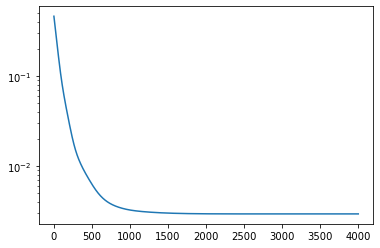

In [21]:
plt.plot(loss_arr)
plt.yscale("log")

In [22]:
# Save Autoencoder
torch.save(model.state_dict(), '../models/ml100k_autoencoder{}.pt'.format(save_tail))